<a href="https://colab.research.google.com/github/chetannitk/BeerDataScienceAssignment/blob/master/notebooks/04-k-mean-clustering-to-find-similar-beer-drinkers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-success">
    <h1> Beer Data Science Assignment <br/></h1>
    K-mean clustering to find similar group of beer drinkers.
</div>


In [1]:
from IPython.display import HTML
import pandas as pd
import os
import numpy as np
from datetime import datetime
import wordcloud
import warnings
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
warnings.filterwarnings('ignore')

BASE_PATH = "../"
INPUT_DATA_PATH = os.path.join(BASE_PATH, "data/raw/BeerDataScienceProject.csv")

In [ ]:
## Upload BeerDataScienceProject.csv file from local system.
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/data/BeerDataScienceProject.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [2]:
!ls -lrt /tmp

total 60
drwx------ 3 root     root     4096 Jun  1 16:03 systemd-private-7b8394c3094347b783aa86ee65a3c8aa-systemd-resolved.service-qQI2cV
drwx------ 3 root     root     4096 Jun  1 16:03 systemd-private-7b8394c3094347b783aa86ee65a3c8aa-systemd-timesyncd.service-Y0nCvX
drwx------ 3 root     root     4096 Jun  1 16:03 systemd-private-7b8394c3094347b783aa86ee65a3c8aa-ModemManager.service-lQxy3b
drwx------ 3 root     root     4096 Jun  1 16:04 systemd-private-7b8394c3094347b783aa86ee65a3c8aa-redis-server.service-ERAkfu
drwxr-xr-x 3 www-data www-data 4096 Jun  1 16:04 www-data-temp-aspnet-0
drwx------ 3 root     root     4096 Jun  1 16:05 systemd-private-7b8394c3094347b783aa86ee65a3c8aa-rtkit-daemon.service-UNNFok
drwx------ 3 root     root     4096 Jun  1 16:05 systemd-private-7b8394c3094347b783aa86ee65a3c8aa-bolt.service-33hoKw
drwx------ 3 root     root     4096 Jun  1 16:05 systemd-private-7b8394c3094347b783aa86ee65a3c8aa-colord.service-EEdyF8
-rw------- 1 chetan   chetan      0 Jun  1

In [3]:
import io
df_beer_raw = pd.read_csv(INPUT_DATA_PATH, encoding="ISO-8859-1")

In [4]:
df_beer_raw.shape

(528870, 13)

In [5]:
df_beer_raw.dtypes

beer_ABV              float64
beer_beerId             int64
beer_brewerId           int64
beer_name              object
beer_style             object
review_appearance     float64
review_palette        float64
review_overall        float64
review_taste          float64
review_profileName     object
review_aroma          float64
review_text            object
review_time             int64
dtype: object

### Data Cleaning
```In the below cell we can see that there are some columns where data is missing. 
   We need to remove those data points from our data set.
```

In [6]:
df_beer_raw.isna().sum()

beer_ABV              20280
beer_beerId               0
beer_brewerId             0
beer_name                 0
beer_style                0
review_appearance         0
review_palette            0
review_overall            0
review_taste              0
review_profileName      115
review_aroma              0
review_text             119
review_time               0
dtype: int64

In [7]:
df_beer = df_beer_raw.dropna()

In [8]:
df_beer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508358 entries, 0 to 528796
Data columns (total 13 columns):
beer_ABV              508358 non-null float64
beer_beerId           508358 non-null int64
beer_brewerId         508358 non-null int64
beer_name             508358 non-null object
beer_style            508358 non-null object
review_appearance     508358 non-null float64
review_palette        508358 non-null float64
review_overall        508358 non-null float64
review_taste          508358 non-null float64
review_profileName    508358 non-null object
review_aroma          508358 non-null float64
review_text           508358 non-null object
review_time           508358 non-null int64
dtypes: float64(6), int64(3), object(4)
memory usage: 54.3+ MB


In [9]:
df_beer = df_beer.reset_index()
df_beer['id'] = df_beer.index

## Data Changes in Raw and Clean dataset

In [10]:
print("Raw data size: ", df_beer_raw.shape[0])
print("Clean data size: ", df_beer.shape[0])
print("Data points difference: ", df_beer_raw.shape[0]-df_beer.shape[0])

Raw data size:  528870
Clean data size:  508358
Data points difference:  20512


### Describe the categorical features

In [11]:
df_beer.describe(include=[np.object])

,beer_name,beer_style,review_profileName,review_text
count,508358,508358,508358,508358
unique,14028,104,22563,508007
top,Sierra Nevada Celebration Ale,American IPA,northyorksammy,#NAME?
freq,2998,42092,1732,90


### Describe the numerical features

In [12]:
df_beer.describe(include=[np.number])

,index,beer_ABV,beer_beerId,beer_brewerId,review_appearance,review_palette,review_overall,review_taste,review_aroma,review_time,id
count,508358.000000,508358.000000,508358.000000,508358.000000,508358.000000,508358.000000,508358.000000,508358.000000,508358.000000,5.083580e+05,508358.00000
mean,263669.490377,7.017400,21824.120840,2534.273207,3.872676,3.768993,3.840805,3.775327,3.827646,1.226175e+09,254178.50000
std,152590.091973,2.204528,22124.969107,5237.843825,0.601764,0.682355,0.706408,0.665586,0.715121,7.530843e+07,146750.45841
min,0.000000,0.010000,5.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,8.843904e+08,0.00000
25%,131284.250000,5.300000,1673.000000,132.000000,3.500000,3.500000,3.500000,3.500000,3.500000,1.177202e+09,127089.25000
50%,263756.500000,6.500000,13850.000000,392.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.241503e+09,254178.50000
75%,395689.750000,8.500000,40418.000000,1315.000000,4.000000,4.000000,4.500000,4.000000,4.500000,1.289073e+09,381267.75000
max,528796.000000,57.700000,77310.000000,27980.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.326277e+09,508357.00000


In [13]:
NUMERICAL_ATTRIBUTE = ['beer_ABV', 'review_appearance', 'review_palette', 
                       'review_overall', 'review_taste', 'review_aroma', 'review_time']
CATEGORICAL_ATTRIBUTE = ['beer_name', 'beer_style', 'review_profileName', 'review_text']

In [14]:
df_beer.sample(4)

,index,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time,id
53761,55896,7.3,38841,688,Newport Storm - Gloria (Cyclone Series),Pumpkin Ale,4.0,4.0,4.0,3.5,fank2788,3.5,12oz bottle served in a pint glass In the glas...,1239929046,53761
353716,367055,5.5,3523,22,Éphémère (Apple),Fruit / Vegetable Beer,4.0,4.0,4.0,3.0,UncleFlip,3.5,"Large, thick white creamy head springs up quic...",1123052341,353716
13730,14976,4.2,512,14,Regatta Golden,Kölsch,4.0,3.5,3.5,3.5,gentlebubbles,3.5,on cask with Halletauer hops It's golden all r...,1105554255,13730
235603,243884,5.4,1984,692,Nut Brown Ale,English Brown Ale,3.0,3.5,3.5,3.0,mooseisloose,3.5,"A recent BOTMC arrival, let's give it a whirl....",1272821677,235603


<div class="alert alert-info">
Convert the review timestamp to datetime format
</div>

In [15]:
df_beer['d_review_time'] = df_beer.review_time.apply(lambda t: datetime.fromtimestamp(t))

In [16]:
df_beer['d_review_time_year'] = df_beer['d_review_time'].dt.year
df_beer['d_review_time_month'] = df_beer['d_review_time'].dt.month

<div class="alert alert-success">
Q7) How do find similar beer drinkers by using written reviews only?   
</div>

In [ ]:
!pip install tensorflow_text

In [17]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
tf.executing_eagerly()

True

In [18]:
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2")

In [19]:
train = df_beer.review_text.tolist()
list_train = [train[i:i+100] for i in range(0,len(train),100)]

In [20]:
from tqdm import tqdm
data = []
for d in tqdm(list_train):
    data.extend(embed(d).numpy())

100%|██████████| 5084/5084 [00:22<00:00, 221.55it/s]


## Optimal number of k in K-Means

100%|██████████| 10/10 [20:03<00:00, 120.32s/it]


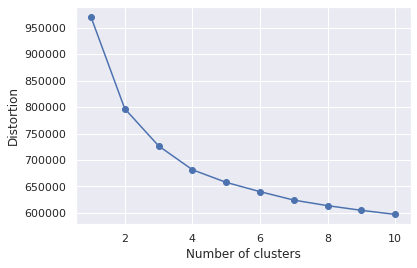

In [23]:
distortions = []
for i in tqdm(range(1, 11)):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(data)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

k=10
km = KMeans(
    n_clusters=k, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(data)